# Optimal Experimental Design - a Demonstration

## Preliminary Information

This is Python notebook demonstrates a recent library I just wrote that can be used to implement 'wet lab', or general-purpose optimal experimental design tasks. In the following cells I will try to explain in detail the capabilities of the library. In order to make use of this library (called optimal_experiment), you need to install the following code:
skopt, sklearn, pymatgen, hyperspy, pyEQL by running:

pip install skopt
pip install sklearn
pip install pymatgen
pip install hyperspy
pip install pyEQL

In your favorite operating system. For more help on how to install new libraries, check the tutorial pages of the corresponding packages.

In order to run this specific library, you have to add the path to the optimal_experiment directory to PYTHONPATH. As a reference, you can do this in Mac OS (and Linux), by modifying the .bash_profile (or .bash_rc or similar) file:

export PYTHONPATH="/Users/rarroyave/optimal_experiment:$PYTHONPATH".


## First, a Demo of skopt

We first start with a demo for skopt, the library that serves as the baseline for optimal_experiment. For more information on this new and powerful library, please consult: <a href=“https://scikit-optimize.github.io/”>skopt tutorial</a>

We start by importing the relevant modules/libraries:

In [33]:
import numpy as np  # numpy is an extremely powerful Python library that implements all kinds of basic numerical stuff.
np.random.seed(1234)
from skopt.benchmarks import branin as branin
import random
from collections import Iterable

%matplotlib inline
import matplotlib.pyplot as plt # matplotlib is a Python library widely used for plotting.
plt.set_cmap("viridis")

from skopt.learning import ExtraTreesRegressor # skopt has implemented many regressors, available from skopt.learning
                                               # submodule. Please consult: https://scikit-optimize.github.io/learning/index.html

from skopt.optimizer import Optimizer   
from skopt.learning import GaussianProcessRegressor
#from skopt import Optimizer

noise_level=0.1

We first define the objective function that we want to optimize:

In [34]:
def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

Let's plot the function to visualize it:

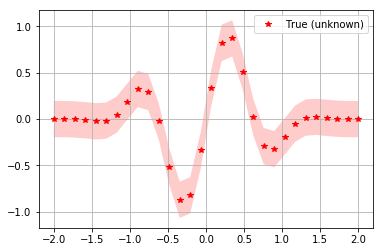

In [35]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 30).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level=0.0) for x_i in x])
plt.plot(x, fx, "r*", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In skopt, you can use a range of regressors used to model the mean response and variance of the surrogate model used to approximate the true function:

In [36]:
etr = ExtraTreesRegressor(random_state=2, n_estimators=200)

We now invoke an instance of the class Optimizer. For more details, refer to: <a href=“https://scikit-optimize.github.io/notebooks/ask-and-tell.html”>skopt tutorial: optimizer</a>

In [37]:
dimensions=[(-2.0, 2.0)]
opt = Optimizer(dimensions, etr, acq_optimizer="sampling",n_random_starts=10)

The method opt.ask() suggests the next point to explore. If there are not a sufficient number of points already acquired, as specified by the parameter n_random_starts.

In [38]:
next_x = opt.ask()
print(next_x)

[1.2085905683206373]


We can then use opt.tell() to tell the optimizer about the outcome of the evaluation of the objective function (or experiment) at the point suggested by opt.ask():

In [39]:
f_val = objective(next_x)
opt.tell(next_x, f_val)

          fun: 0.019824387717172161
    func_vals: array([ 0.01982439])
       models: []
 random_state: <mtrand.RandomState object at 0x7f072833d510>
        space: Space([Real(low=-2.0, high=2.0, prior=uniform, transform=identity)])
        specs: None
            x: [1.2085905683206373]
      x_iters: [[1.2085905683206373]]

We can do this multiple times in a loop:

In [40]:
for i in range(9):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)

We can now plot the random suggestions and the first model that has been fit:

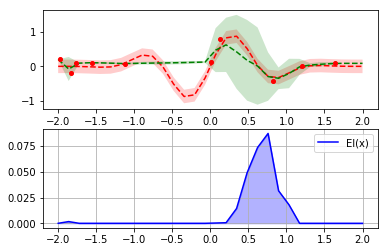

In [41]:
from skopt.acquisition import gaussian_ei

def plot_optimizer(opt, x, fx):
    model = opt.models[-1]
    x_model = opt.space.transform(x.tolist())

    # Plot true function.
    plt.subplot(2, 1, 1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot Model(x) + contours
    y_pred, sigma = model.predict(x_model, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(opt.Xi, opt.yi,
             "r.", markersize=8, label="Observations")
    
    # why are we looking at a gaussian EI model plot if the regressor is an extra trees regressor?
    #
    #
    acq = gaussian_ei(x_model, model, y_opt=np.min(opt.yi))
    # shift down to make a better plot
    #acq = (4*acq-2)
    plt.subplot(2, 1, 2)
    
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), 0.0, acq.ravel(), alpha=0.3, color='blue')

    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')

plot_optimizer(opt, x, fx)


Let us sample a few more points and plot the optimizer again:

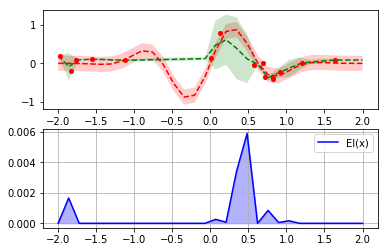

In [42]:

for i in range(5):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)

plot_optimizer(opt, x, fx)

Let's see how this works usig a different regressor:

In [43]:
from skopt.learning import GaussianProcessRegressor

from skopt.space import check_dimension
from skopt.space import Categorical
from skopt.space import Space
from skopt.learning.gaussian_process.kernels import ConstantKernel
from skopt.learning.gaussian_process.kernels import HammingKernel
from skopt.learning.gaussian_process.kernels import Matern
from sklearn.utils import check_random_state

rng = check_random_state(1234)

dim_types = [check_dimension(d) for d in dimensions]
# We will first normalize dimensions (features) so GP work within (0,1) domain:
transformed_dims = []
for dim_type, dim in zip(dim_types, dimensions):
    transformed_dims.append(check_dimension(dim, transform="normalize"))

space = Space(transformed_dims)



# We then pre-calculate the kernels of the GP taking into account this normalization:

cov_amplitude = ConstantKernel(1.0, (0.01, 1000.0))
other_kernel = Matern(
                length_scale=np.ones(space.transformed_n_dims),
                length_scale_bounds=[(0.01, 100)] * space.transformed_n_dims,
                nu=2.5)
noise="gaussian"

base_estimator = GaussianProcessRegressor(
        kernel=cov_amplitude * other_kernel,
        normalize_y=True, random_state=rng, alpha=0.0, noise=noise,
        n_restarts_optimizer=2)

#gpr = GaussianProcessRegressor(random_state=2)

In [44]:
opt2 = Optimizer([(-2.0, 2.0)], base_estimator, acq_optimizer="sampling",n_random_starts=10)
next_x = opt2.ask()
print(next_x)
f_val = objective(next_x)
opt2.tell(next_x, f_val)

[-1.4306157979523397]


          fun: 0.0041096642939490481
    func_vals: array([ 0.00410966])
       models: []
 random_state: <mtrand.RandomState object at 0x7f072833d510>
        space: Space([Real(low=-2.0, high=2.0, prior=uniform, transform=identity)])
        specs: None
            x: [-1.4306157979523397]
      x_iters: [[-1.4306157979523397]]

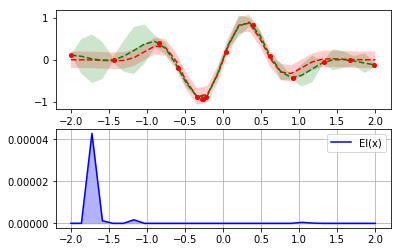

In [45]:
for i in range(14):
    next_x = opt2.ask()
    f_val = objective(next_x)
    opt2.tell(next_x, f_val)
plot_optimizer(opt2, x, fx)

## Now we will get started with demo

We will demonstrate the new module by applying it to the optimization of the braning function:

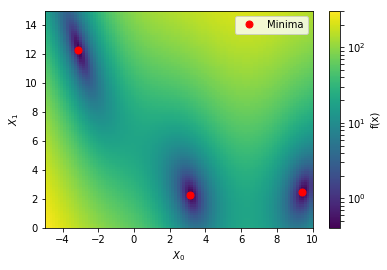

In [46]:
from matplotlib.colors import LogNorm
from skopt.benchmarks import branin as _branin


def branin(x, noise_level=0.):
    return _branin(x) + noise_level * np.random.randn()

noise_level=0.

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val,noise_level=noise_level) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])

plot_branin()

We will first import two of the major classes implemented in optimal_experiment: Sample() and Experimental_Space().
Experimental_Space() is a Class that helps implement an experimental design framework. Sample() is the fundamental Class that impements an experimental observation (i.e. Sample). Below I will demonstrate their main functionalities.



In [47]:

from experiment.samples import *

noise_level=0.00

We invoke an instance of the Experimental_Space() class. We will then add features, 'x1' and 'x2', which are dedined over the ranges (-5,10) and (0,15), respectively. See plot above and you will recognize that the 'x axis' corresponds to 'x1', while the 'y axis' corresponds to 'x2':

In [48]:
es=Experimental_Space()
es.add_feature('x1',(-5.,10.))
es.add_feature('x2',(0.,15.))

es

{'dimensions': [(-5.0, 10.0), (0.0, 15.0)],
 'features': [{'dimension': (-5.0, 10.0), 'name': 'x1', 'use': True},
  {'dimension': (0.0, 15.0), 'name': 'x2', 'use': True}],
 'features_list': ['x1', 'x2'],
 'samples': [],
 'space': None}

We will set the dimensions of the experimental space and will tell the Experimental_Space() instance that the dimensions should be transformable. This is important as the regressors usually work with transformed (re-scaled, normalized, etc) dimensions:

In [49]:
es.set_dimensions()
es.transform_dimensions()
es['dimensions']

[Real(low=-5.0, high=10.0, prior=uniform, transform=normalize),
 Real(low=0.0, high=15.0, prior=uniform, transform=normalize)]

Note that the 'dimensions' attribute of the Experimental_Space() instance indicates that the space to be explored consists of two Real dimensions (-5,10) and (0,15) that can be transformed through normalization.

Optimization of an experimental design space works over a finite set of possible experimental observations. We will first create a grid of experimental points through the following commands:


In [50]:
x1_v=np.linspace(0,10.,250)
x2_v=np.linspace(0,15.,250)
x_ax,y_ax=np.meshgrid(x1_v,x2_v)
vals=np.c_[x_ax.ravel(),y_ax.ravel()]
print('Total number of experiments to explore: '+str(len(vals)))

Total number of experiments to explore: 62500


A proper efficient search over the design space should be able to find the minimum of the function in a relatively small number of 'tries'. We want to know what is the answer before we embark on this excercise:

In [51]:
y=[branin(val,noise_level=noise_level) for val in vals]
solution=min(y)
print(solution)

0.398331768814


We create a function that evaluates branin at arbitrary two-dimensional points:


In [52]:
def evaluate_branin(x_list,noise_level=noise_level):
    vals=[]
    for x in x_list:
        vals.append(branin(x,noise_level=noise_level))
    return vals

Using standard tricks for <a href=“https://docs.python.org/2/tutorial/datastructures.html”>list comprehension</a> in Python, we create a list of samples of the same size as the experimental space to be explored:


In [53]:
samples_list = [Sample() for i in range(len(vals))]

We will then proceed to add the 'experimental conditions' for each of the samples. After a sample is created, we add it to the sample list of the experimental space.

In [54]:
for i in np.arange(len(vals)):
    samples_list[i].add_feature('x1',vals[i][0])
    samples_list[i].add_feature('x2',vals[i][1])
    samples_list[i].add_observable('y')
    samples_list[i].make_lists()
    es.add_sample(samples_list[i])

Experimental_Space is basically a dictionary, with the following keys/attributes:

In [55]:
print(es.keys())

dict_keys(['features', 'samples', 'dimensions', 'features_list', 'space'])


Here is how one sample looks like:


In [56]:
print(es['samples'][0])

{'features': {'x1': 0.0, 'x2': 0.0}, 'observables': {'y': {'name': 'y', 'value': None, 'measured': False, 'to_measure': False}}, 'id': 'DZBTIZWCCMWP'}


Notice how each sample has many features, including a dictionary of 'observables', a dictionary of 'features' as well as a unique, ramdom id.

We will proceed to sort the sample list by sample id, we will proceed to set the dimensions of the experimental space and will create the lists of samples measured, un_measured as well as the samples to measure next:

In [57]:
es.sort_samples()
es.set_space()
es.make_lists(observable='y')
es.update(observable='y')
es.transform_dimensions()


In this notebook, so far, we have used the Optimizer Class implemented in skopt:

We will now override this, by importing the new Optimizer class

In [58]:
from experiment.optimizer import *

Optimizer

experiment.optimizer.Optimizer

We will create an instance of an ExtraTreesRegressor and we will invoke an instance of the new Optimizer class. Notice that this new Optimizer class is initialized with an experimental space, in this case named 'es' as shown above.

In [59]:
gpr = GaussianProcessRegressor(random_state=2)
etr = ExtraTreesRegressor(random_state=2, n_estimators=500)
opt = Optimizer(es, 'y', "GP", acq_optimizer="sampling",acq_func="gp_hedge")

Note that we have told the Optimizer that the acquisition function is "gp_hedge". This is an implementation of the Multi-arm banding idea I discussed in class.
We will now proceed to ask Optimizer for the next experiment to run. The new ask() method returns the id of the sample to measure next:

In [60]:
sample_ids=opt.ask()
print(sample_ids)

['VWPXKPJDCIIO']


We will get the feature set that corresponds to this sample id:

In [61]:
x=opt.experimental_space.get_list_of_feature_lists_by_ids(sample_ids)
print(x)

[[2.570281124497992, 7.0481927710843371]]


In [62]:
[p in opt.space for p in x]

[True]

We will then proceed to 'make the measurement' by evaluating the branin function at that point. Note that by default, only when 10 points have been measured will the Optimizer proceed to suggest points to explored based on acquisition function.

In [64]:
vals=evaluate_branin(x,noise_level=noise_level) 
print(sample_ids)
print(type(sample_ids))
print(vals)
print(type(vals))
opt.tell(sample_ids,'y',vals)

['VWPXKPJDCIIO']
<class 'list'>
[20.288154654518625]
<class 'list'>


          fun: 20.288154654518625
    func_vals: array([ 20.28815465,  20.28815465])
       models: []
 random_state: <mtrand.RandomState object at 0x7f072833d510>
        space: Space([Real(low=-5.0, high=10.0, prior=uniform, transform=normalize),
       Real(low=0.0, high=15.0, prior=uniform, transform=normalize)])
        specs: None
            x: [2.570281124497992, 7.0481927710843371]
      x_iters: [[2.570281124497992, 7.0481927710843371], [2.570281124497992, 7.0481927710843371]]

Note that by default, only when 10 points have been measured will the Optimizer proceed to suggest points to explored based on acquisition function:

In [32]:
print(opt.experimental_space['measured_samples'])

[{'features': {'x1': 10.0, 'x2': 12.891566265060241}, 'observables': {'y': {'name': 'y', 'value': 99.727741667798497, 'measured': True, 'to_measure': False, 'std': 0.0}}, 'id': 'FALUTKXIKXPY'}]


We will proceed to do some more ask() and tell():

In [ ]:
sample_ids=opt.ask()
vals=[]
vals.append(branin(x[0],noise_level=noise_level))
opt.tell(sample_ids,'y',vals)
print(opt.experimental_space['measured_samples'])

In [ ]:
sample_ids=opt.ask()
vals=[]
vals.append(branin(x[0],noise_level=noise_level))
opt.tell(sample_ids,'y',vals)
print(opt.experimental_space['measured_samples'])

In [ ]:
for i in range(7):
    sample_ids=opt.ask()
    vals=evaluate_branin(x,noise_level=noise_level) 
    opt.tell(sample_ids,'y',vals)

We now have ten samples that have been measured:

In [ ]:
print(len(opt.experimental_space['measured_samples']))

We will now begin to start non-random, guided suggestions:

In [ ]:
sample_ids=opt.ask()
vals=evaluate_branin(x,noise_level=noise_level) 
opt.tell(sample_ids,'y',vals)

Observe how now Optimizer is greating regression models based on the data:

In [ ]:
opt.models[0]


The best solution so far, can be found and compared to solution:

In [ ]:
print(min(opt.yi))
print(solution)

We are far away, but let's see how we do in 10 more experiments:

In [ ]:
for i in range(10):
    sample_ids=opt.ask()
    x=opt.experimental_space.get_list_of_feature_lists_by_ids(sample_ids)
    vals=evaluate_branin(x,noise_level=noise_level) 
    opt.tell(sample_ids,'y',vals)
print(len(opt.yi))
print(min(opt.yi))
print(solution)  
fraction=len(opt.yi)/len(opt.experimental_space['samples'])
print(fraction)
print('Only {0:.3f}. % of the space has been explored'.format(fraction*100.))

We are still far away, but lets see how we do in 20 more experiments:

In [ ]:
for i in range(20):
    sample_ids=opt.ask()
    x=opt.experimental_space.get_list_of_feature_lists_by_ids(sample_ids)
    vals=evaluate_branin(x,noise_level=noise_level) 
    opt.tell(sample_ids,'y',vals)
print(len(opt.yi))
print(min(opt.yi))
print(solution)    
fraction=len(opt.yi)/len(opt.experimental_space['samples'])
print(fraction)
print('Only {0:.3f}. % of the space has been explored'.format(fraction*100.))

We now do the same thing as before, to enable some plotting:

In [ ]:
opt2 = Optimizer(es, 'y', etr, acq_optimizer="sampling",acq_func="gp_hedge",acq_optimizer_kwargs={"n_points":500})

In [ ]:
res=[]
for i in range(50):
    sample_ids=opt2.ask()
    x=opt2.experimental_space.get_list_of_feature_lists_by_ids(sample_ids)
    vals=evaluate_branin(x,noise_level=noise_level) 
    res.append(opt2.tell(sample_ids,'y',vals))
    
print(min(opt2.yi))
print(solution)    
fraction=len(opt2.yi)/len(opt.experimental_space['samples'])
print(fraction)
print('Only {0:.3f}. % of the space has been explored'.format(fraction*100.))    

In [ ]:
from skopt.plots import plot_convergence

In [ ]:
plot = plot_convergence(("results", res), 
                        true_minimum=0.397887, yscale="log")

plot.legend(loc="best", prop={'size': 6}, numpoints=1);

Let's do something even cooler. Suppose that we are aksed to evaluate the performance of different combinations of regressors ["GP", "ET", "RF"] (gaussian process, extra tree, random forest) and criteria ["EI","PI","LCB","gp_hedge"] (expected improvement, probability of improvement, lower confidence bound as well as gp_hedge). How to do this in a Pythonic way?

Let's look at the following example:

In [65]:
import itertools
a = ['foo', 'bar', 'baz']
b = ['x', 'y', 'z', 'w']

combined_list=[]
for r in itertools.product(a, b): 
    combined_list.append((r[0],r[1]))
                         
print(combined_list)
    

[('foo', 'x'), ('foo', 'y'), ('foo', 'z'), ('foo', 'w'), ('bar', 'x'), ('bar', 'y'), ('bar', 'z'), ('bar', 'w'), ('baz', 'x'), ('baz', 'y'), ('baz', 'z'), ('baz', 'w')]


Let's do the same with our example:

In [ ]:
a =  ["GP", "ET", "RF"] 
b = ["EI","PI","LCB","gp_hedge"]
combined_list=[]
for r in itertools.product(a, b): 
    combined_list.append((r[0],r[1]))
                         
print(combined_list)

Let's iterate over this list of 'tuples':

In [ ]:
list_of_optimal_experiments=[]

for t in combined_list:
    performance_dict={}
    performance_dict['optimizer']=Optimizer(es, 'y', t[0], acq_optimizer="sampling",acq_func=t[1],acq_optimizer_kwargs={"n_points":500})
    performance_dict['res']=[]
    performance_dict['regressor']=t[0]
    performance_dict['policy']=t[1]
    list_of_optimal_experiments.append(performance_dict)

In [ ]:
print(list_of_optimal_experiments[0])

Let's do 50 experiments for each combination:

In [ ]:
number_experiments = 50

In [ ]:
for oe in list_of_optimal_experiments:
    for i in range(number_experiments):
        sample_ids=oe['optimizer'].ask()
        x=oe['optimizer'].experimental_space.get_list_of_feature_lists_by_ids(sample_ids)
        vals=evaluate_branin(x,noise_level=noise_level) 
        oe['res'].append((oe['optimizer'].tell(sample_ids,'y',vals)))
    

In [ ]:
lt=[]

In [ ]:
for oe in list_of_optimal_experiments:
    lt.append((oe['regressor']+'_'+oe['policy'],oe['res'][-1:]))

In [ ]:
plot = plot_convergence(lt[0],lt[1],lt[2],lt[3],lt[4],lt[5],lt[6],lt[7],lt[8],lt[9],lt[10],lt[11],
                        true_minimum=0.397887, yscale="log")

plot.legend(loc="best", prop={'size': 6}, numpoints=1);

In [ ]:
len(lt[0][1])

Let's extract the coordinates of the minima found by the different regressor+policy combinations:

In [ ]:
for oe in list_of_optimal_experiments:
    yi=oe['optimizer'].yi
    Xi=oe['optimizer'].Xi
    oe['xsol']=Xi[np.argmin(yi)]

In [ ]:
def plot_branin_with_solutions(list_of_optimal_experiments):
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val,noise_level=noise_level) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    markers=['md','mo','m8','m*','bd','bo','b8','b*','kd','ko','k8','k*']
    
    marker_counter=0
    for oe in list_of_optimal_experiments:
        ax.plot([oe['xsol'][0]], [oe['xsol'][1]], markers[marker_counter], markersize=8, lw=0, label=oe['regressor']+'_'+oe['policy'])
        marker_counter+=1
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    #ax.legend(loc="best", numpoints=1,prop={'size':6})
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,prop={'size':6})

    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])

In [ ]:
plot_branin_with_solutions(list_of_optimal_experiments)

In [ ]:
n_groups=4

rsol_GP=[]
rsol_RF=[]
rsol_ET=[]

for oe in list_of_optimal_experiments:
    if oe['regressor'] == "GP":
        yi=oe['optimizer'].yi
        rsol_GP.append(min(yi)/solution)
    elif oe['regressor'] == "ET":
        yi=oe['optimizer'].yi
        rsol_ET.append(min(yi)/solution)
    elif oe['regressor'] == "RF":
        yi=oe['optimizer'].yi
        rsol_RF.append(min(yi)/solution)    

fig,ax=plt.subplots()
index=np.arange(n_groups)
bar_width=0.2
opacity=0.4

rects1 = plt.bar(index, rsol_GP, bar_width,
                 alpha=opacity,
                 color='b',
                 label='GP')

rects2 = plt.bar(index + bar_width, rsol_ET, bar_width,
                 alpha=opacity,
                 color='r',
                 label='ET')

rects3 = plt.bar(index + 2*bar_width, rsol_RF, bar_width,
                 alpha=opacity,
                 color='k',
                 label='RF')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.xlabel('Regressor Type')
plt.ylabel('Relative Solution')

plt.legend()

plt.tight_layout()



plt.show()

We can see how different regressor types work. Overall, for this problem, it is evident that GP regressors are better at finding the solution than the other regressors, with the RandomForest regressor performing the worst, under some policy choices.